In [3]:
!pip install mediapipe


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.8 MB 1.3 MB/s 


In [4]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

In [5]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [6]:
photo_names = [file for file in os.listdir("/content/AFLW2000") if file.endswith(".jpg")]


In [51]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        shape = img.shape 
        relative_x = int(tdx * shape[1])
        relative_y = int(tdy * shape[0])
        tdx = relative_x
        tdy = relative_y
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2
       

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [8]:
imgs_data = []
for i in range(len(photo_names)):
  faceModule = mediapipe.solutions.face_mesh
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      image_path = '/content/AFLW2000/'+photo_names[i]
      image = cv2.imread(image_path)
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks is not None: 
        face = results.multi_face_landmarks[0]
        dimensions = []
        for landmark in face.landmark:
            x = landmark.x
            y = landmark.y
            dimensions = dimensions + [x, y]
        
        mat_file = sio.loadmat(image_path.strip('.jpg') +'.mat')
        pose_para = mat_file["Pose_Para"][0][:3]
        pitch = pose_para[0]
        yaw = pose_para[1]
        roll = pose_para[2]
        dimensions = dimensions + [pitch, yaw, roll]
        imgs_data.append(dimensions)

In [9]:
df = pd.DataFrame(imgs_data)

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,936,937,938
0,0.471241,0.691123,0.417033,0.635525,0.458873,0.647285,0.412849,0.572590,0.409050,0.616496,...,0.497286,0.481722,0.505382,0.595097,0.449863,0.605026,0.430024,-0.127748,0.787311,-0.307763
1,0.538288,0.703810,0.519384,0.641631,0.522234,0.654304,0.469476,0.569937,0.511568,0.621372,...,0.471524,0.500767,0.481960,0.613570,0.398655,0.618912,0.386701,-0.256462,-0.068172,-0.296042
2,0.533752,0.663713,0.580310,0.632869,0.538632,0.637606,0.565972,0.573881,0.588070,0.617730,...,0.522149,0.556534,0.528403,0.570175,0.517160,0.571647,0.508113,-0.854659,-1.192600,1.097198
3,0.552425,0.661107,0.576439,0.607050,0.546191,0.626425,0.549339,0.562329,0.578728,0.591816,...,0.525257,0.534557,0.528699,0.554392,0.512045,0.555616,0.505540,-0.073279,-0.904444,-0.053832
4,0.486130,0.660555,0.473843,0.611173,0.485149,0.629223,0.473919,0.557612,0.474141,0.594046,...,0.524144,0.531494,0.526399,0.630080,0.516404,0.641647,0.509669,-0.013633,0.270767,0.071436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,0.560837,0.646204,0.572567,0.591360,0.548008,0.615164,0.534726,0.553615,0.570715,0.576390,...,0.521959,0.513561,0.524144,0.532400,0.503203,0.532140,0.498273,0.346542,-0.958447,-0.520749
1849,0.646249,0.617714,0.643961,0.556823,0.623830,0.595543,0.590350,0.534984,0.636711,0.542377,...,0.520496,0.551746,0.520856,0.553336,0.512672,0.546436,0.506900,1.474152,-0.688101,-1.573545
1850,0.561292,0.652004,0.523098,0.630301,0.533762,0.629967,0.463917,0.597850,0.509394,0.620633,...,0.506230,0.457990,0.516380,0.508721,0.404348,0.509571,0.392279,-0.238633,-0.004876,-0.907422
1851,0.508580,0.675030,0.502707,0.607793,0.503551,0.627871,0.479890,0.544562,0.500590,0.587733,...,0.492627,0.517410,0.496877,0.611699,0.466396,0.619480,0.459217,-0.035426,-0.058997,-0.104905


In [11]:
df.columns = [*df.columns[:-3], 'pitch', 'yaw', 'roll']

In [12]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,0.471241,0.691123,0.417033,0.635525,0.458873,0.647285,0.412849,0.572590,0.409050,0.616496,...,0.497286,0.481722,0.505382,0.595097,0.449863,0.605026,0.430024,-0.127748,0.787311,-0.307763
1,0.538288,0.703810,0.519384,0.641631,0.522234,0.654304,0.469476,0.569937,0.511568,0.621372,...,0.471524,0.500767,0.481960,0.613570,0.398655,0.618912,0.386701,-0.256462,-0.068172,-0.296042
2,0.533752,0.663713,0.580310,0.632869,0.538632,0.637606,0.565972,0.573881,0.588070,0.617730,...,0.522149,0.556534,0.528403,0.570175,0.517160,0.571647,0.508113,-0.854659,-1.192600,1.097198
3,0.552425,0.661107,0.576439,0.607050,0.546191,0.626425,0.549339,0.562329,0.578728,0.591816,...,0.525257,0.534557,0.528699,0.554392,0.512045,0.555616,0.505540,-0.073279,-0.904444,-0.053832
4,0.486130,0.660555,0.473843,0.611173,0.485149,0.629223,0.473919,0.557612,0.474141,0.594046,...,0.524144,0.531494,0.526399,0.630080,0.516404,0.641647,0.509669,-0.013633,0.270767,0.071436


In [13]:
def preprocessing(df, landmark_no, to_pred = False):
  pivot_x = landmark_no + (landmark_no - 2)
  pivot_y = pivot_x + 1

 
  if to_pred:
    all_x_corr = [i for i in df.columns if i % 2== 0]
    all_y_corr = [i for i in range(1, df.shape[1], 2)]
  
  else:
    all_x_corr = [i for i in df.columns[:-3] if i % 2== 0]
    all_y_corr = [i for i in range(1, df.shape[1] - 3, 2)]
  
  all_x_corr.remove(pivot_x)
  all_y_corr.remove(pivot_y)
  df.loc[:, all_x_corr] = df.loc[:, all_x_corr].values - df.loc[:, pivot_x].values.reshape(df.shape[0], 1)
  df.loc[:, all_y_corr] = df.loc[:, all_y_corr].values - df.loc[:, pivot_y].values.reshape(df.shape[0], 1)

  return df
  


In [14]:
df_clean = df.copy()

In [15]:
preprocessing(df_clean, 6);

In [16]:
df_clean.head()

,0,1,2,3,4,5,6,7,8,9,...,929,930,931,932,933,934,935,pitch,yaw,roll
0,0.058233,0.101559,0.004024,0.045961,0.045865,0.057722,-0.000159,-0.016974,-0.003958,0.026932,...,-0.092278,0.068713,-0.084182,0.182089,-0.139700,0.192018,-0.159540,-0.127748,0.787311,-0.307763
1,0.039182,0.114311,0.020278,0.052133,0.023128,0.064806,-0.029629,-0.019561,0.012463,0.031874,...,-0.117974,0.001662,-0.107538,0.114464,-0.190843,0.119807,-0.202797,-0.256462,-0.068172,-0.296042
2,-0.050547,0.069203,-0.003989,0.038360,-0.045667,0.043096,-0.018327,-0.020628,0.003771,0.023220,...,-0.072360,-0.027766,-0.066106,-0.014124,-0.077349,-0.012652,-0.086397,-0.854659,-1.192600,1.097198
3,-0.017726,0.087210,0.006287,0.033153,-0.023961,0.052529,-0.020813,-0.011568,0.008577,0.017919,...,-0.048640,-0.035595,-0.045197,-0.015759,-0.061852,-0.014536,-0.068357,-0.073279,-0.904444,-0.053832
4,0.006954,0.087624,-0.005333,0.038242,0.005973,0.056291,-0.005257,-0.015319,-0.005035,0.021115,...,-0.048787,0.052318,-0.046532,0.150905,-0.056527,0.162471,-0.063262,-0.013633,0.270767,0.071436


In [17]:
x = df_clean.loc[:, df_clean.columns[:-3]]
y = df_clean.loc[:, df_clean.columns[-3:]]

# **Model Training**

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [19]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

**Divide the labels for three models**


In [20]:
yaw_train = y_train['yaw']
roll_train = y_train['roll']
pitch_train = y_train['pitch']

yaw_test = y_test['yaw']
roll_test = y_test['roll']
pitch_test = y_test['pitch']



In [21]:
def grid_eval(model, x_test, y_test):
  print("best parameters for model:", model.best_params_)
  print("best score :", model.best_score_)
  print("r2 score on test set:", r2_score(y_test, model.predict(x_test)))


In [22]:

parameters = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100, 1000],'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

yaw_model = GridSearchCV(SVR(), parameters, cv= 5 , n_jobs=-1)
pitch_model = GridSearchCV(SVR(), parameters, cv= 5 , n_jobs=-1)
roll_model = GridSearchCV(SVR(), parameters, cv= 5 , n_jobs=-1)

In [23]:
yaw_model.fit(X_train, yaw_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']})

In [25]:
grid_eval(yaw_model, X_test, yaw_test)

best parameters for model: {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
best score : 0.8755745381510188
r2 score on test set: 0.9227534640482336


In [26]:
yaw_model.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

**Saving The Model** 


In [27]:
joblib.dump(yaw_model, 'yaw.pkl')

['yaw.pkl']

**Train The pitch model** 

In [28]:
pitch_model.fit(X_train, pitch_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['rbf']})

In [29]:
grid_eval(pitch_model, X_test, pitch_test)

best parameters for model: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
best score : 0.42137627716870385
r2 score on test set: 0.5961002583943995


In [30]:
pitch_model.best_params_

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}

**Train The Roll Model**

In [31]:
roll_model.fit(X_train, roll_train);

In [32]:
roll_model.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [33]:
grid_eval(roll_model, X_test, roll_test)

best parameters for model: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best score : 0.5087142556316568
r2 score on test set: 0.6095504504985978


# Train random forest

In [34]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [50, 55, 60, 70, 75, 80, 90, 94, 100]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
# [5, 8, 15, 25, 30]
max_depth = [int(x) for x in np.linspace(1, 50, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10] 

bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [35]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(x, y['pitch'])

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [1, 5, 10, 15, 20, 25, 30,
                                                      35, 40, 45, 50, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 55, 60, 70, 75, 80,
                                                         90, 94, 100]},
                   random_state=42)

In [37]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 80}

In [38]:
rf_random.best_score_

0.18390939287599614

train pitch model

In [39]:
forest_pitch = RandomForestRegressor(n_estimators = 50)
forest_pitch.fit(x, y['pitch'])

RandomForestRegressor(n_estimators=50)

In [40]:
r2_score(y['pitch'], forest_pitch.predict(x))

0.8143525720453558

In [41]:
forest_pitch.get_params() 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [42]:
# saving model
joblib.dump(forest_pitch, 'forest_pitch.pkl')

['forest_pitch.pkl']

roll model train

In [43]:
forest_roll = RandomForestRegressor()
forest_roll.fit(x, y['roll'])

RandomForestRegressor()

In [44]:
r2_score(y['roll'], forest_roll.predict(x))

0.8816651085618004

In [45]:
# saving model
joblib.dump(forest_pitch, 'forest_roll.pkl')

['forest_roll.pkl']

picked yaw model trained using SVR

picked pitch, roll models trained using random forest regression

# Testing on a new photo

In [46]:
def pred_features(img_name):
  '''takes an image name in directory as input returns a pandas dataframe of featres'''
  dims = []

  faceModule = mediapipe.solutions.face_mesh
  # loading image and its correspinding mat file
  with faceModule.FaceMesh(static_image_mode=True) as faces:
      # loading the image
      
      image = cv2.imread('/content/' + img_name+ '.jpg')
      # processing the face to extract the landmark points (468 point) for each x,y,z
      results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      if results.multi_face_landmarks != None: 
        # looping over the faces in the image
        for face in results.multi_face_landmarks:
            for landmark in face.landmark:
                x = landmark.x
                y = landmark.y
                dims.append(x)
                dims.append(y)
  
  dims_df = pd.DataFrame(dims).T  
  preprocessing(dims_df, 6)

  return dims_df              



def draw_image(img_name, features_df = None):
  '''passed .jpg image file name, gets landmarks of photo scaled and draws predicted p, y, r'''
  if not features_df:
    features_df = pred_features(img_name)
    
  image = cv2.imread('/content/' + img_name+ '.jpg')
  # centered around lanmark 6 
  cv2_imshow(draw_axis(image, forest_pitch.predict(features_df)[0], yaw_model.predict(features_df)[0], forest_roll.predict(features_df)[0], tdx = features_df[10][0], tdy = features_df[11][0]))


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


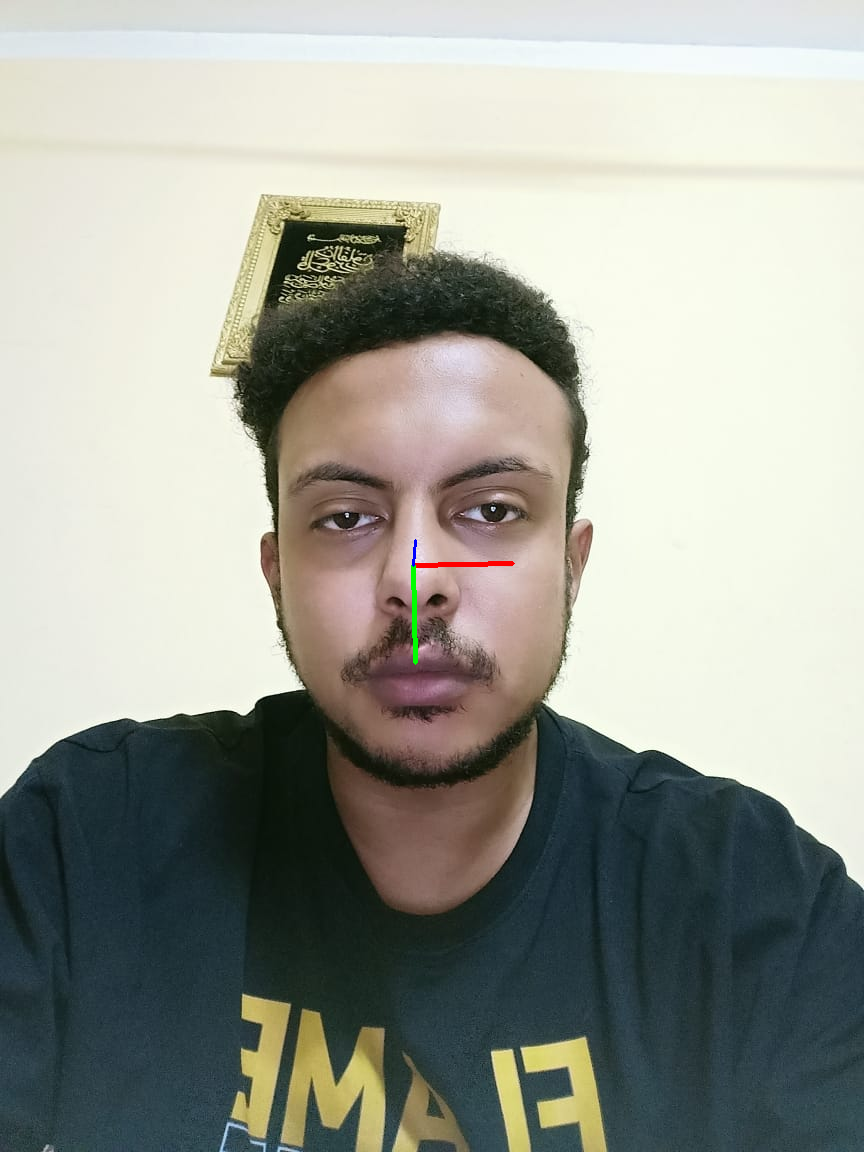

In [54]:
draw_image('ME')

In [73]:
cap = cv2.VideoCapture('me.mp4')

if (cap.isOpened()== False): 
  print("Error opening video  file")

#see number of frames
int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

325

In [74]:
faceModule = mediapipe.solutions.face_mesh

faces = faceModule.FaceMesh(static_image_mode=True)

In [75]:
#set first dimension as number of frames
test_Data = np.zeros((429,936))
data_point = 0
feature = 0

In [76]:
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    results = faces.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks is not None:
      #don't forget to preprocess landmarks
      print(data_point)
      for face in results.multi_face_landmarks:
        feature=0
        for landmark in face.landmark:
          #test_Data[data_point][feature]   =  
          #test_Data[data_point][feature+1] =  
          feature = feature + 2
      data_point = data_point + 1
  else:
    break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
cap = cv2.VideoCapture('me.mp4')

if (cap.isOpened()== False): 
  print("Error opening video  file")

In [78]:
img_array = []
test_image = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == True:
      # frame = draw_axis(frame, # use your model to predict the angels)
      img_array.append(frame)
      height, width, layers = frame.shape
      size  = (width,height)
      test_image = test_image + 1
    else:
      break

out = cv2.VideoWriter('/content/drive/MyDrive/video.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
    print(i)
out.release()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [79]:
cap.release()
cv2.destroyAllWindows()
test_Data.shape

(429, 936)